In [ ]:
from sklearn.datasets import fetch_openml 

X, y = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False)



In [ ]:
print(f"X shape: {X.shape}, y shape: {y.shape}")


X shape: (70000, 784), y shape: (70000,)


In [ ]:
import numpy as np
from gtda.plotting import plot_heatmap

im8_idx = np.flatnonzero(y == "0")[0] 
img8 = X[im8_idx].reshape(28, 28) 
plot_heatmap(img8)

In [ ]:
from sklearn.model_selection import train_test_split
train_size, test_size = 1000, 200 # Reshape to (n_samples, n_pixels_x, n_pixels_y) 
X = X.reshape((-1, 28, 28)) 
X_train, X_test, y_train, y_test = train_test_split( X, y, train_size=train_size, test_size=test_size, stratify=y, random_state=666 ) 
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}") 
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (1000, 28, 28), y_train shape: (1000,)
X_test shape: (200, 28, 28), y_test shape: (200,)


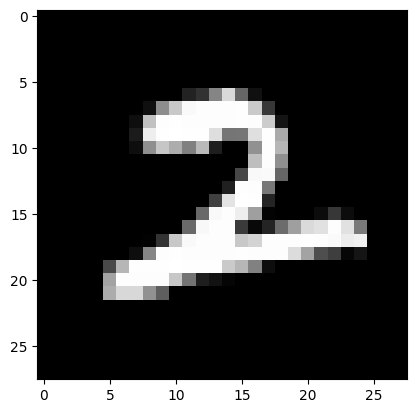

In [ ]:
plt.imshow(X_test[5], cmap="gray")

C:\Users\jawor\AppData\Local\Temp\ipykernel_14700\1312748792.py:4: FutureWarning:

`seed` is a deprecated argument name for `random_noise`. It will be removed in version 0.23. Please use `rng` instead.

C:\Users\jawor\AppData\Local\Temp\ipykernel_14700\1312748792.py:5: FutureWarning:

`seed` is a deprecated argument name for `random_noise`. It will be removed in version 0.23. Please use `rng` instead.



Text(0.5, 1.0, 'Noisy Image with Random Noise')

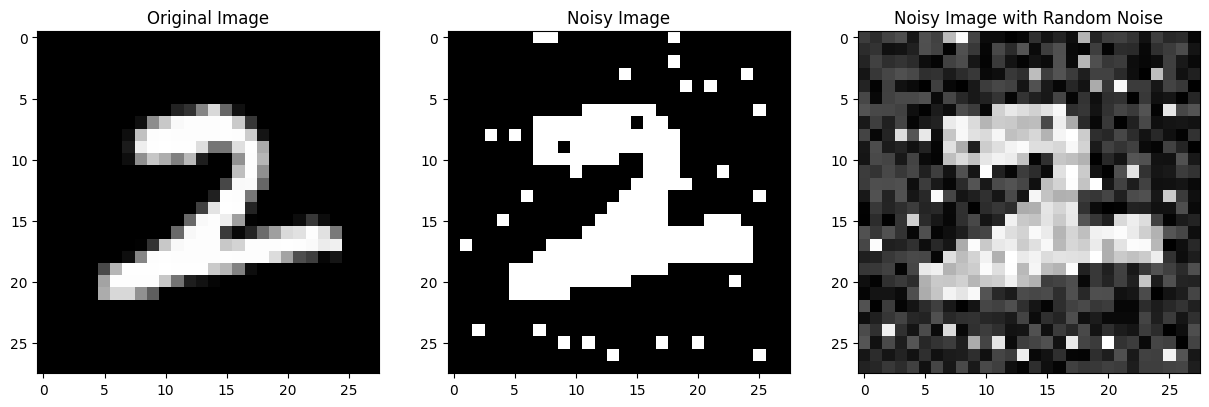

In [ ]:
# distort X_train and X_test a little bit not using giotto

from skimage.util import random_noise
X_train_noisy = random_noise(X_train, mode="s&p",amount=0.1, seed=666)
X_test_noisy = random_noise(X_test, mode="s&p",amount=0.1, seed=666)

# generate random noise matrix of size X_train_noisy.shape and X_test_noisy.shape but without original image

X_train_noisy_random = np.random.rand(*X_train_noisy.shape)
X_test_noisy_random = np.random.rand(*X_test_noisy.shape)

# for each image in X_train_noisy and X_test_noisy, we will add the random noise matrix to the image

X_train_noisy_random = X_train_noisy + X_train_noisy_random
X_test_noisy_random = X_test_noisy + 0.5*X_test_noisy_random

# plot the original image, the noisy image and the noisy image with random noise

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(X_test[5], cmap="gray")
ax[0].set_title("Original Image")
ax[1].imshow(X_test_noisy[5], cmap="gray")
ax[1].set_title("Noisy Image")
ax[2].imshow(X_test_noisy_random[5], cmap="gray")
ax[2].set_title("Noisy Image with Random Noise")






In [ ]:
import matplotlib.pyplot as plt

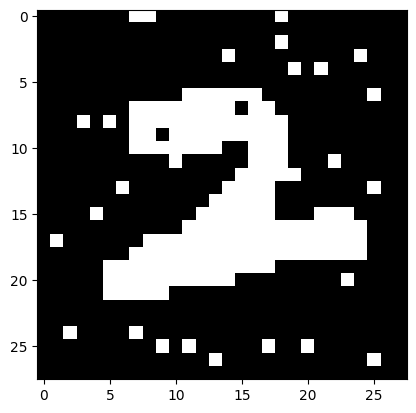

In [ ]:
X_test_noisy.shape
plt.imshow(X_test_noisy[5], cmap="gray")

In [ ]:
from gtda.images import Binarizer 

# Pick out index of first 8 image 
im8_idx = np.flatnonzero(y_train == "8")[0] # Reshape to (n_samples, n_pixels_x, n_pixels_y) format 
im8 = X_train[im8_idx][None, :, :] 
binarizer = Binarizer(threshold=0.4) 
im8_binarized = binarizer.fit_transform(im8) 
binarizer.plot(im8_binarized)


In [ ]:
from gtda.images import RadialFiltration, HeightFiltration
radial_filtration = RadialFiltration(center=np.array([20,6])) 
im8_filtration = radial_filtration.fit_transform(im8_binarized) 
radial_filtration.plot(im8_filtration, colorscale="jet")


In [ ]:
from gtda.homology import CubicalPersistence 
cubical_persistence = CubicalPersistence(n_jobs=-1) 
im8_cubical = cubical_persistence.fit_transform(im8_filtration) 
cubical_persistence.plot(im8_cubical)


In [ ]:
from gtda.diagrams import Scaler 
scaler = Scaler() 
im8_scaled = scaler.fit_transform(im8_cubical) 
scaler.plot(im8_scaled)


In [ ]:
import matplotlib.pyplot as plt

In [ ]:
from gtda.diagrams import HeatKernel
heat = HeatKernel(sigma=.15, n_bins=28, n_jobs=-1) 
im8_heat = heat.fit_transform(im8_scaled) # Visualise the heat kernel for H1 
heat.plot(im8_heat, homology_dimension_idx=1, colorscale='jet')




In [ ]:
from sklearn.pipeline import Pipeline
from gtda.diagrams import Amplitude

In [ ]:
from gtda.diagrams import HeatKernel, PersistenceImage, BettiCurve, PersistenceLandscape, Silhouette

In [ ]:
from sklearn.pipeline import make_pipeline, make_union 
from gtda.diagrams import PersistenceEntropy 
from gtda.images import HeightFiltration 

direction_list = [[1, 0], [1, 1], [0, 1], [-1, 1], [-1, 0], [-1, -1], [0, -1], [1, -1]] 
center_list = [ [13, 6], [6, 13], [13, 13], [20, 13], [13, 20], [6, 6], [6, 20], [20, 6], [20, 20], ] 

# Creating a list of all filtration transformer
filtration_list = (
    [ HeightFiltration(direction=np.array(direction), n_jobs=-1) for direction in direction_list ] +
    [ RadialFiltration(center=np.array(center), n_jobs=-1) for center in center_list]
)

# Creating the diagram generation pipeline 
diagram_steps = [
    [ Binarizer(threshold=0.4, n_jobs=-1), filtration, CubicalPersistence(n_jobs=-1), Scaler(n_jobs=-1), ]
    for filtration in filtration_list
]

# Listing all metrics we want to use to extract diagram amplitudes 
metric_list = [
    {"metric": "bottleneck", "metric_params": {}},
    {"metric": "wasserstein", "metric_params": {"p": 1}},
    {"metric": "wasserstein", "metric_params": {"p": 2}},
    {"metric": "landscape", "metric_params": {"p": 1, "n_layers": 1, "n_bins": 100}},
    {"metric": "landscape", "metric_params": {"p": 1, "n_layers": 2, "n_bins": 100}},
    {"metric": "landscape", "metric_params": {"p": 2, "n_layers": 1, "n_bins": 100}},
    {"metric": "landscape", "metric_params": {"p": 2, "n_layers": 2, "n_bins": 100}},
    {"metric": "betti", "metric_params": {"p": 1, "n_bins": 100}},
    {"metric": "betti", "metric_params": {"p": 2, "n_bins": 100}},
    {"metric": "heat", "metric_params": {"p": 1, "sigma": 1.6, "n_bins": 100}},
    {"metric": "heat", "metric_params": {"p": 1, "sigma": 3.2, "n_bins": 100}},
    {"metric": "heat", "metric_params": {"p": 2, "sigma": 1.6, "n_bins": 100}},
    {"metric": "heat", "metric_params": {"p": 2, "sigma": 3.2, "n_bins": 100}},
]

# feature_union 
feature_union = make_union(
    PersistenceImage(sigma=.15, n_bins=28, n_jobs=-1) # or heat kernel, or possibly any other (but rational and well-fitting to model) vector representation of the diagram
)

tda_union = make_union(
    *[make_pipeline(*diagram_step, feature_union) for diagram_step in diagram_steps],
    n_jobs=-1
)


In [ ]:
from sklearn import set_config 
set_config(display='diagram') 
tda_union


FeatureUnion(n_jobs=-1,
             transformer_list=[('pipeline-1',
                                Pipeline(steps=[('binarizer',
                                                 Binarizer(n_jobs=-1,
                                                           threshold=0.4)),
                                                ('heightfiltration',
                                                 HeightFiltration(direction=array([1, 0]),
                                                                  n_jobs=-1)),
                                                ('cubicalpersistence',
                                                 CubicalPersistence(n_jobs=-1)),
                                                ('scaler', Scaler(n_jobs=-1)),
                                                ('featureunion',
                                                 FeatureUnion(transformer_list=[('persistenceimage',
                                                                                 Persisten...
                               ('pipeline-17',
                                Pipeline(steps=[('binarizer',
                                                 Binarizer(n_jobs=-1,
                                                           threshold=0.4)),
                                                ('radialfiltration',
                                                 RadialFiltration(center=array([20, 20]),
                                                                  n_jobs=-1)),
                                                ('cubicalpersistence',
                                                 CubicalPersistence(n_jobs=-1)),
                                                ('scaler', Scaler(n_jobs=-1)),
                                                ('featureunion',
                                                 FeatureUnion(transformer_list=[('persistenceimage',
                                                                                 PersistenceImage(n_bins=28,
                                                                                                  n_jobs=-1,
                                                                                                  sigma=0.15))]))]))])

In [ ]:
X_train.shape

(1000, 28, 28)

In [ ]:
X_train_tda_clean = tda_union.fit_transform(X_train)
print(X_train_tda_clean.shape)

X_test_tda_clean = tda_union.transform(X_test)
print(X_test_tda_clean.shape)


(1000, 34, 28, 28)
(200, 34, 28, 28)


In [ ]:
X_train_tda_8 = tda_union.fit_transform(X_train_noisy_random) 
X_train_tda_8.shape




(1000, 34, 28, 28)

In [ ]:
X_test_tda_8 = tda_union.transform(X_test_noisy_random)
X_test_tda_8.shape

(200, 34, 28, 28)

In [ ]:
X_train_tda_good = np.transpose(X_train_tda_8, (0, 2, 3, 1))
X_test_tda_good = np.transpose(X_test_tda_8, (0, 2, 3, 1))

In [ ]:
X_train_tda_clean_good = np.transpose(X_train_tda_clean, (0, 2, 3, 1))
X_test_tda_clean_good = np.transpose(X_test_tda_clean, (0, 2, 3, 1))
#shapes
print(X_train_tda_good.shape)
print(X_test_tda_good.shape)

(1000, 28, 28, 34)
(200, 28, 28, 34)


In [ ]:
X_test_tda_good.shape

(200, 28, 28, 34)

In [ ]:
from sklearn.ensemble import RandomForestClassifier 
rf = RandomForestClassifier() 
rf.fit(X_train_tda, y_train) 
X_test_tda = tda_union.transform(X_test) 
rf.score(X_test_tda, y_test)


0.7

9


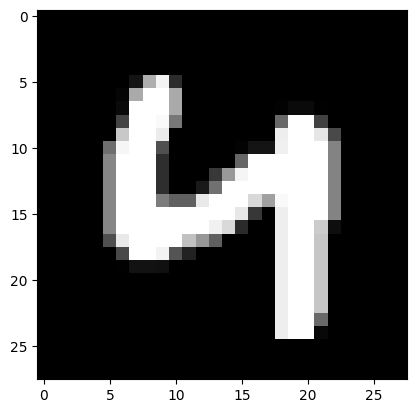

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(X[222], cmap="gray")
print(y[153])

In [ ]:
test_one = X[222][None, :, :]

test_one_tda = tda_union.transform(test_one)

rf.predict(test_one_tda)

array(['4'], dtype=object)

In [ ]:
import tensorflow as tf


In [ ]:

model = tf.keras.models.Sequential()
#CNN
model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 34)))

model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))

model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(10, activation='softmax'))

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),  
              metrics=['accuracy'])

model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_35 (Conv2D)          (None, 26, 26, 32)        9824      
                                                                 
 max_pooling2d_23 (MaxPooli  (None, 13, 13, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_36 (Conv2D)          (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_24 (MaxPooli  (None, 5, 5, 64)          0         
 ng2D)                                                           
                                                                 
 conv2d_37 (Conv2D)          (None, 3, 3, 64)          36928     
                                                                 
 flatten_16 (Flatten)        (None, 576)             

In [ ]:
y_train = y_train.astype(int)
y_test = y_test.astype(int)

model.fit(X_train_tda_clean_good, y_train, epochs=10, batch_size=1, validation_data=(X_test_tda_good, y_test))

Epoch 1/10
1000/1000 [==============================] - 16s 13ms/step - loss: 1.2612 - accuracy: 0.6020 - val_loss: 3.8855 - val_accuracy: 0.1950
Epoch 2/10
1000/1000 [==============================] - 13s 13ms/step - loss: 0.6582 - accuracy: 0.8280 - val_loss: 6.1243 - val_accuracy: 0.1700
Epoch 3/10
1000/1000 [==============================] - 12s 12ms/step - loss: 0.5453 - accuracy: 0.8360 - val_loss: 15.7657 - val_accuracy: 0.1550
Epoch 4/10
1000/1000 [==============================] - 13s 13ms/step - loss: 0.4684 - accuracy: 0.8830 - val_loss: 2.7769 - val_accuracy: 0.2350
Epoch 5/10
1000/1000 [==============================] - 13s 13ms/step - loss: 0.3563 - accuracy: 0.9100 - val_loss: 7.9923 - val_accuracy: 0.2250
Epoch 6/10
1000/1000 [==============================] - 13s 13ms/step - loss: 0.4896 - accuracy: 0.8890 - val_loss: 6.4556 - val_accuracy: 0.2450
Epoch 7/10
1000/1000 [==============================] - 13s 13ms/step - loss: 0.2992 - accuracy: 0.9130 - val_loss: 7.8325 

In [ ]:

# save x_test_tda and y_test
np.save('x_test_tda.npy', x_test_tda)
np.save('y_test.npy', y_test)


In [ ]:
# model standardowy bez tda
model2 = tf.keras.models.Sequential()
#CNN
model2.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))

model2.add(tf.keras.layers.MaxPooling2D((2, 2)))
model2.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
model2.add(tf.keras.layers.MaxPooling2D((2, 2)))
model2.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))

model2.add(tf.keras.layers.Flatten())

model2.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dropout(0.3))

model2.add(tf.keras.layers.Dense(10, activation='softmax'))

model2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),  
              metrics=['accuracy'])

model2.summary()


Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_30 (Conv2D)          (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_20 (MaxPooli  (None, 13, 13, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_31 (Conv2D)          (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_21 (MaxPooli  (None, 5, 5, 64)          0         
 ng2D)                                                           
                                                                 
 conv2d_32 (Conv2D)          (None, 3, 3, 64)          36928     
                                                                 
 flatten_14 (Flatten)        (None, 576)             

In [ ]:
# fit model2
model2.fit(X_train, y_train, epochs=10, batch_size=1, validation_data=(X_test_noisy_random, y_test))

Epoch 1/10
1000/1000 [==============================] - 14s 12ms/step - loss: 1.4772 - accuracy: 0.6820 - val_loss: 2.2927 - val_accuracy: 0.1850
Epoch 2/10
1000/1000 [==============================] - 13s 13ms/step - loss: 0.4569 - accuracy: 0.8620 - val_loss: 2.2986 - val_accuracy: 0.0950
Epoch 3/10
1000/1000 [==============================] - 13s 13ms/step - loss: 0.2701 - accuracy: 0.9210 - val_loss: 2.2974 - val_accuracy: 0.0950
Epoch 4/10
1000/1000 [==============================] - 14s 14ms/step - loss: 0.3367 - accuracy: 0.9030 - val_loss: 2.2997 - val_accuracy: 0.0950
Epoch 5/10
1000/1000 [==============================] - 11s 11ms/step - loss: 0.2971 - accuracy: 0.9210 - val_loss: 2.3007 - val_accuracy: 0.1200
Epoch 6/10
1000/1000 [==============================] - 12s 12ms/step - loss: 0.1588 - accuracy: 0.9540 - val_loss: 2.2937 - val_accuracy: 0.0950
Epoch 7/10
1000/1000 [==============================] - 11s 11ms/step - loss: 0.2642 - accuracy: 0.9380 - val_loss: 2.3022 -

In [ ]:
# non convolutional model for standard mnist
model3 = tf.keras.models.Sequential()
model3.add(tf.keras.layers.Flatten(input_shape=(28, 28)))
model3.add(tf.keras.layers.Dense(128, activation='relu'))
model3.add(tf.keras.layers.Dense(10, activation='softmax'))

model3.compile(optimizer='adam',
                loss=tf.keras.losses.SparseCategoricalCrossentropy(),  
                metrics=['accuracy'])

model3.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_10 (Flatten)        (None, 784)               0         
                                                                 
 dense_20 (Dense)            (None, 128)               100480    
                                                                 
 dense_21 (Dense)            (None, 10)                1290      
                                                                 
Total params: 101770 (397.54 KB)
Trainable params: 101770 (397.54 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
y_train = y_train.astype(int)
y_test = y_test.astype(int)

# fit model3
model3.fit(X_train, y_train, epochs=10, batch_size=1, validation_data=(X_test_noisy_random, y_test))

Epoch 1/10
1000/1000 [==============================] - 9s 9ms/step - loss: 0.5976 - accuracy: 0.8800 - val_loss: 2.3568 - val_accuracy: 0.0950
Epoch 2/10
1000/1000 [==============================] - 11s 11ms/step - loss: 0.6720 - accuracy: 0.8740 - val_loss: 2.3988 - val_accuracy: 0.0950
Epoch 3/10
1000/1000 [==============================] - 11s 11ms/step - loss: 0.4363 - accuracy: 0.9140 - val_loss: 2.4206 - val_accuracy: 0.0950
Epoch 4/10
1000/1000 [==============================] - 8s 8ms/step - loss: 1.1610 - accuracy: 0.8680 - val_loss: 2.4387 - val_accuracy: 0.0950
Epoch 5/10
 127/1000 [==>...........................] - ETA: 6s - loss: 1.0496 - accuracy: 0.8976

KeyboardInterrupt: 